### MACHINE LEARNING PREDICTION OF INDIA'S AIR QUALITY INDEX (AQI)
I used machine learning to predict the air quality index of Delhi, India.

I then visualised the result on time-series data across 293 days (nearly 10 months, from the end of July 2020 to June 2021)


In [1]:
#load libraries for model training
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data = pd.read_csv("/home/jovyan/Analysis/AQI_Analysis/air-quality-data-in-india/air_quality_index.csv") #reading the data

In [80]:
data.columns

Index(['DATE', 'COUNTRY', 'CITY', 'VALUE', 'date'], dtype='object')

In [3]:
### Changing datatypes for date

data["date"] = pd.to_datetime(data["DATE"],dayfirst=True)

### creatng unique dataframe for country India
india_data = data[data["COUNTRY"] == "IN"]

### creating copy of datasets

india_copy = india_data.copy()
unique_city_india = list(india_copy["CITY"].unique())

In [6]:
india_copy["year"] = india_copy["date"].dt.year #convert to date format
unique_year = list(india_copy["year"].unique())

In [8]:
### Making Predictions on one of the most polluted states of India - Delhi

delhi = india_copy[india_copy["CITY"] == "Delhi"]

df = delhi.reset_index()["VALUE"]
delhi

delhi.drop(columns = ["DATE","COUNTRY","CITY","year"], axis = 1, inplace = True) #obtaining the air quality index values of India

training_set = delhi.iloc[:700, 0:1].values
test_set = delhi.iloc[700:, 0:1].values

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)


In [9]:
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 700):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(X_train.shape)

(640, 60, 1)


In [14]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 256, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 256, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 256, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [16]:
# Fitting the RNN to the Training set
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint("/home/jovyan/Analysis/AQI_Analysis/AQI_ML_Model.h5", verbose=1, save_best_only=True)
result = model.fit(X_train, y_train, epochs = 30, batch_size = 16, callbacks=[checkpointer])

Epoch 1/30
640/640 [==============================] - 14s 22ms/step - loss: 0.0234
Epoch 2/30
640/640 [==============================] - 13s 20ms/step - loss: 0.0181
Epoch 3/30
640/640 [==============================] - 13s 20ms/step - loss: 0.0181
Epoch 4/30
640/640 [==============================] - 13s 20ms/step - loss: 0.0179
Epoch 5/30
640/640 [==============================] - 13s 20ms/step - loss: 0.0172
Epoch 6/30
640/640 [==============================] - 13s 20ms/step - loss: 0.0185
Epoch 7/30
640/640 [==============================] - 13s 20ms/step - loss: 0.0176
Epoch 8/30
640/640 [==============================] - 13s 20ms/step - loss: 0.0180
Epoch 9/30
640/640 [==============================] - 13s 20ms/step - loss: 0.0177
Epoch 10/30
640/640 [==============================] - 13s 20ms/step - loss: 0.0171
Epoch 11/30
640/640 [==============================] - 13s 20ms/step - loss: 0.0174
Epoch 12/30
640/640 [==============================] - 13s 20ms/step - loss: 0.0177
E

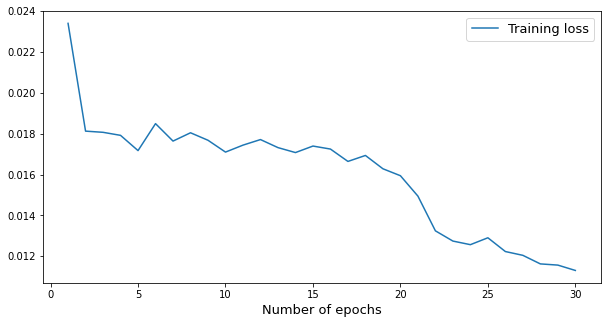

In [31]:
### plotting the loss
plt.figure(figsize = (10,5))
loss = result.history['loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.xlabel("Number of epochs", fontsize = 13)
plt.legend(fontsize = 13)
plt.show()

In [66]:
len(delhi)

893

In [70]:
# Getting the predicted poluution level 

#Testing out 293 time-series items
dataset_train = delhi.iloc[:600, 0:1]
dataset_test = delhi.iloc[600:, 0:1]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 353):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

# prediction 
predicted_pollution = model.predict(X_test)
predicted_pollution = sc.inverse_transform(predicted_pollution)
print(len(dataset_test))
## making a copy of the dataset
dataset_test_copy = dataset_test.copy()
test_data = pd.merge(dataset_test_copy,delhi, left_index = True, right_index = True)
print(len(dataset_test_copy))
test_data.drop(columns = ["VALUE_x"], inplace = True)

## resting index value for the dataset
dataset_test_copy.reset_index(drop = True, inplace = True)

test_data.reset_index(drop = True, inplace = True)

(293, 60, 1)
293
293


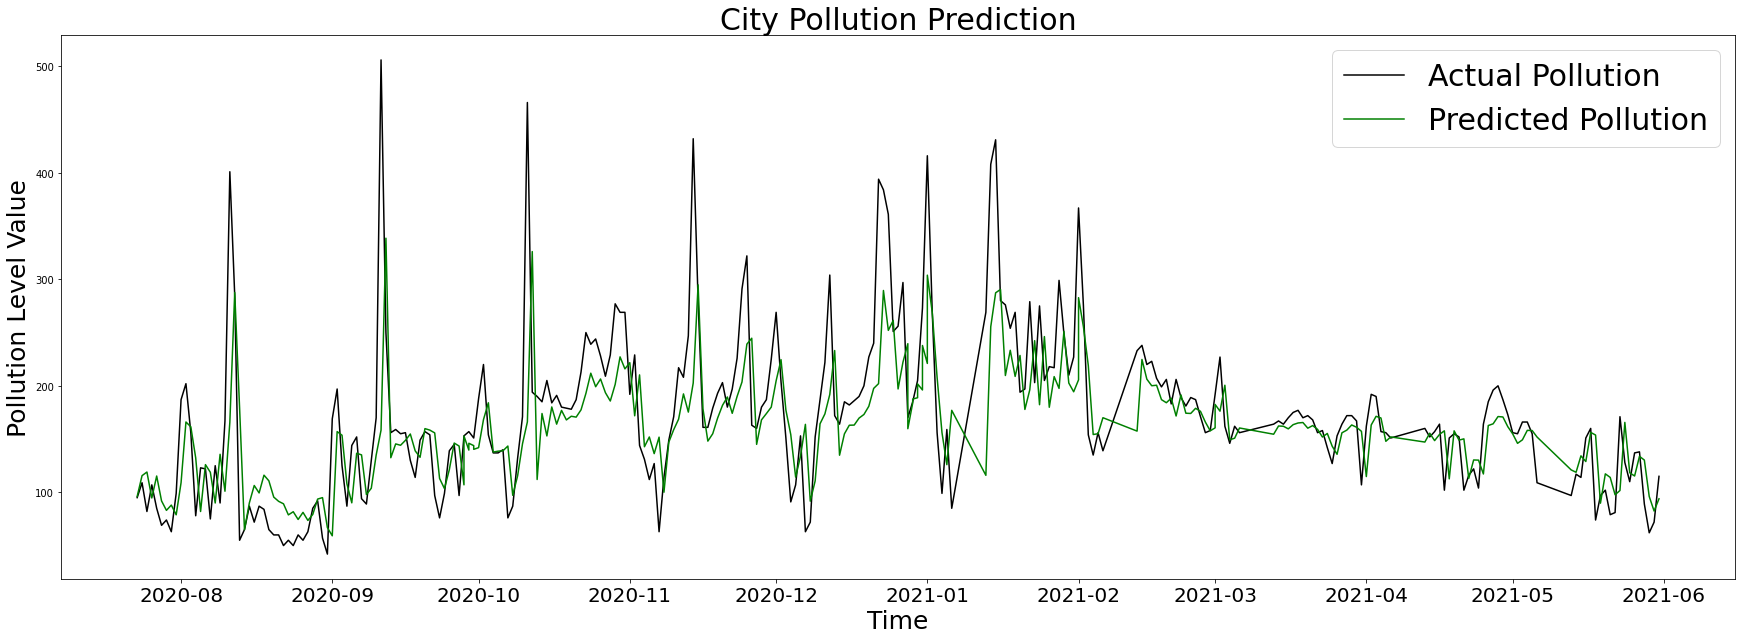

In [75]:
## plotting actual vs prediction
plt.figure(figsize = (30,10))
plt.plot(test_data.loc[:, 'date'], dataset_test_copy, color = 'black', label = 'Actual Pollution')
plt.plot(test_data.loc[:, 'date'], predicted_pollution, color = 'green', label = 'Predicted Pollution')
plt.title('City Pollution Prediction', fontsize=30)
plt.xlabel('Time', fontsize=25)
plt.ylabel('Pollution Level Value', fontsize=25)
plt.legend(fontsize=30)
plt.xticks(fontsize=20)
plt.savefig('/home/jovyan/Analysis/AQI_Analysis/AQL_ML_Prediction.png', dpi=200, bbox_inches="tight", pad_inches=0.05)
plt.show()